<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Gesture recognition tutorial
 * Sandeep Mistry - Arduino
 * Don Coleman - Chariot Solutions

 
https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment 

The next cell sets up the dependencies in required for the notebook, run it.

In [ ]:
# Setup environment
#!apt-get -qq install xxd
#!pip install pandas numpy matplotlib
#!pip install tensorflow
#done

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)
print(pd.__version__)
print(np.__version__)


2.12.0
1.5.3
1.22.4


# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the files tab
1. Drag the 'gestures.csv' files from your computer to the tab to upload them into colab.

# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "up",
    "down",
    #"left",
    #"right",
    "circle",
    "counter",
    "pan"
]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("/content/" + gesture + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.12.0

Processing index 0 for gesture 'up'.
	There are 497 recordings of the up gesture.
Processing index 1 for gesture 'down'.
	There are 464 recordings of the down gesture.
Processing index 2 for gesture 'circle'.
	There are 526 recordings of the circle gesture.
Processing index 3 for gesture 'counter'.
	There are 503 recordings of the counter gesture.
Processing index 4 for gesture 'pan'.
	There are 563 recordings of the pan gesture.
Data set parsing and preparation complete.


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [ ]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [ ]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
# Adam optimization
# learning_rate = 0.0002 for 5 gestures and (4)smaller batch size is better
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'accuracy'])
history = model.fit(inputs_train, outputs_train, epochs=100, batch_size=16, validation_data=(inputs_validate, outputs_validate))

Epoch 1/100
96/96 [==============================] - 1s 4ms/step - loss: 0.1594 - mae: 0.3190 - accuracy: 0.1888 - val_loss: 0.1581 - val_mae: 0.3179 - val_accuracy: 0.1680
Epoch 2/100
96/96 [==============================] - 0s 2ms/step - loss: 0.1574 - mae: 0.3169 - accuracy: 0.2364 - val_loss: 0.1563 - val_mae: 0.3157 - val_accuracy: 0.2480
Epoch 3/100
96/96 [==============================] - 0s 2ms/step - loss: 0.1548 - mae: 0.3141 - accuracy: 0.3338 - val_loss: 0.1528 - val_mae: 0.3116 - val_accuracy: 0.3691
Epoch 4/100
96/96 [==============================] - 0s 2ms/step - loss: 0.1508 - mae: 0.3092 - accuracy: 0.3566 - val_loss: 0.1485 - val_mae: 0.3062 - val_accuracy: 0.3145
Epoch 5/100
96/96 [==============================] - 0s 2ms/step - loss: 0.1454 - mae: 0.3020 - accuracy: 0.3697 - val_loss: 0.1416 - val_mae: 0.2974 - val_accuracy: 0.3262
Epoch 6/100
96/96 [==============================] - 0s 2ms/step - loss: 0.1380 - mae: 0.2916 - accuracy: 0.3690 - val_loss: 0.1325 - v

## Verify 

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

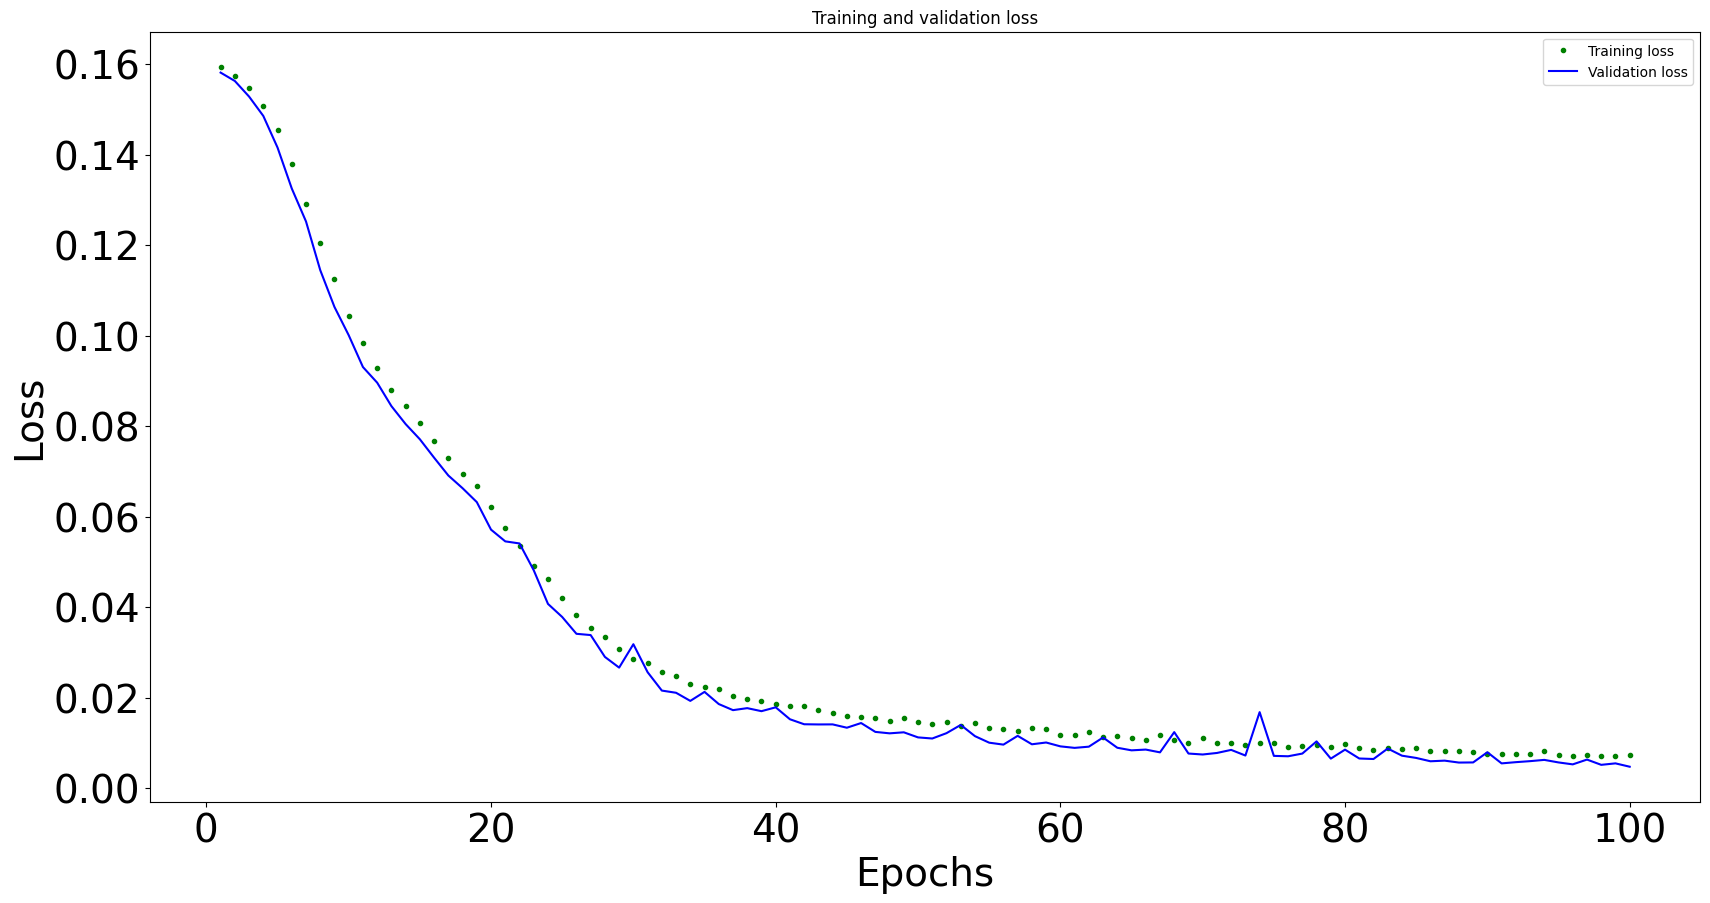

[20.0, 10.0]


In [ ]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["axes.labelsize"] = 28
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

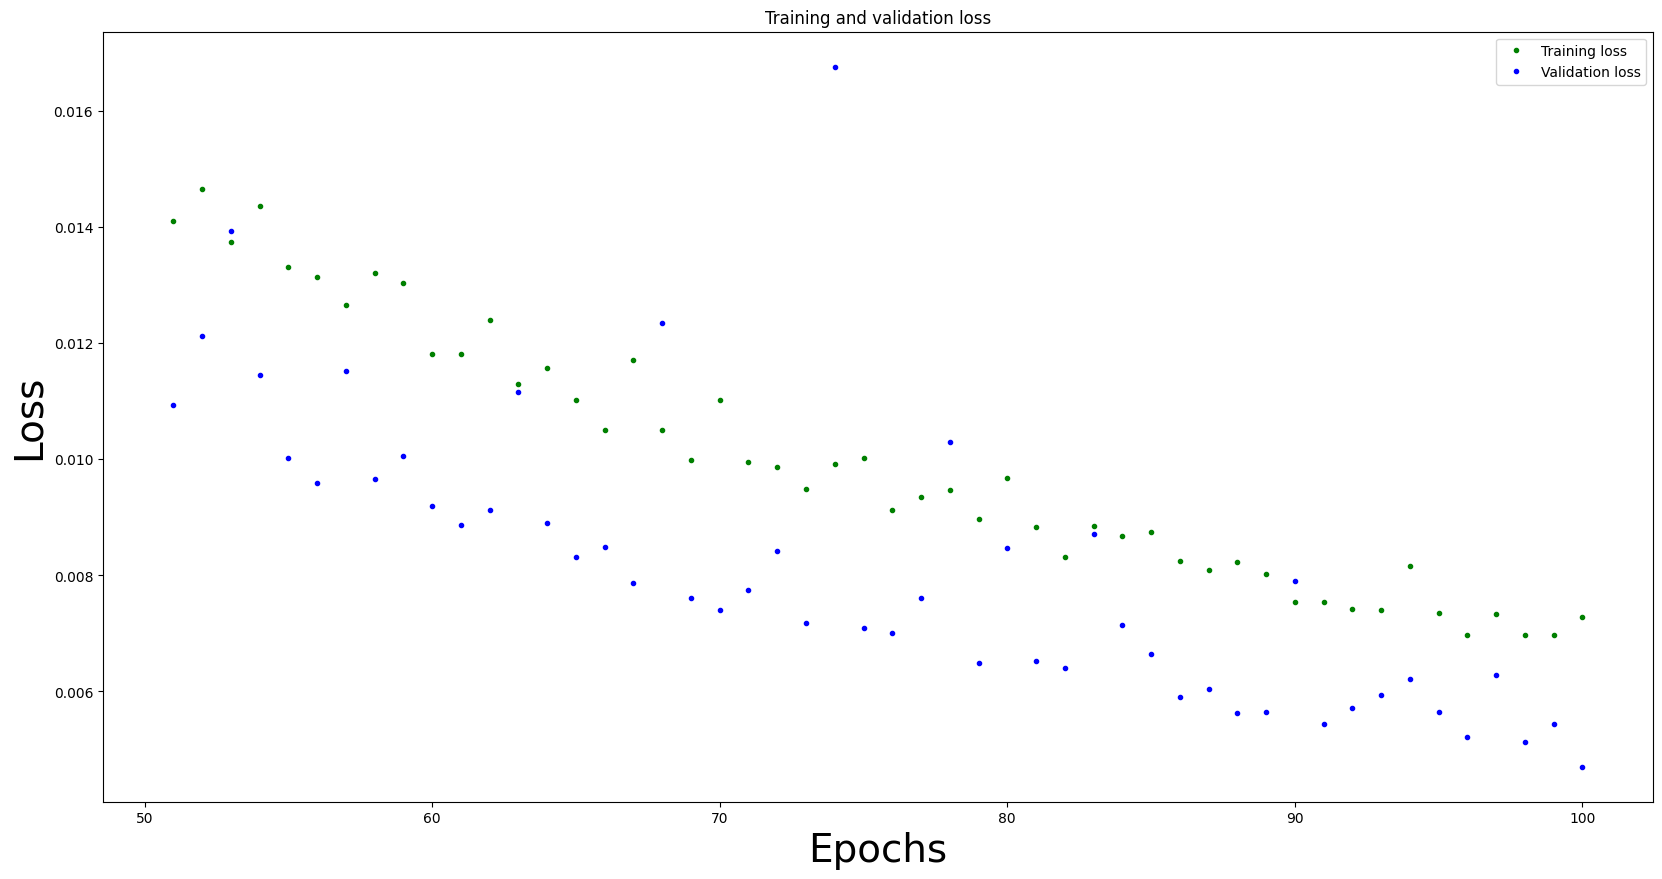

In [ ]:
# graph the loss again skipping a bit of the start
SKIP = 50
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



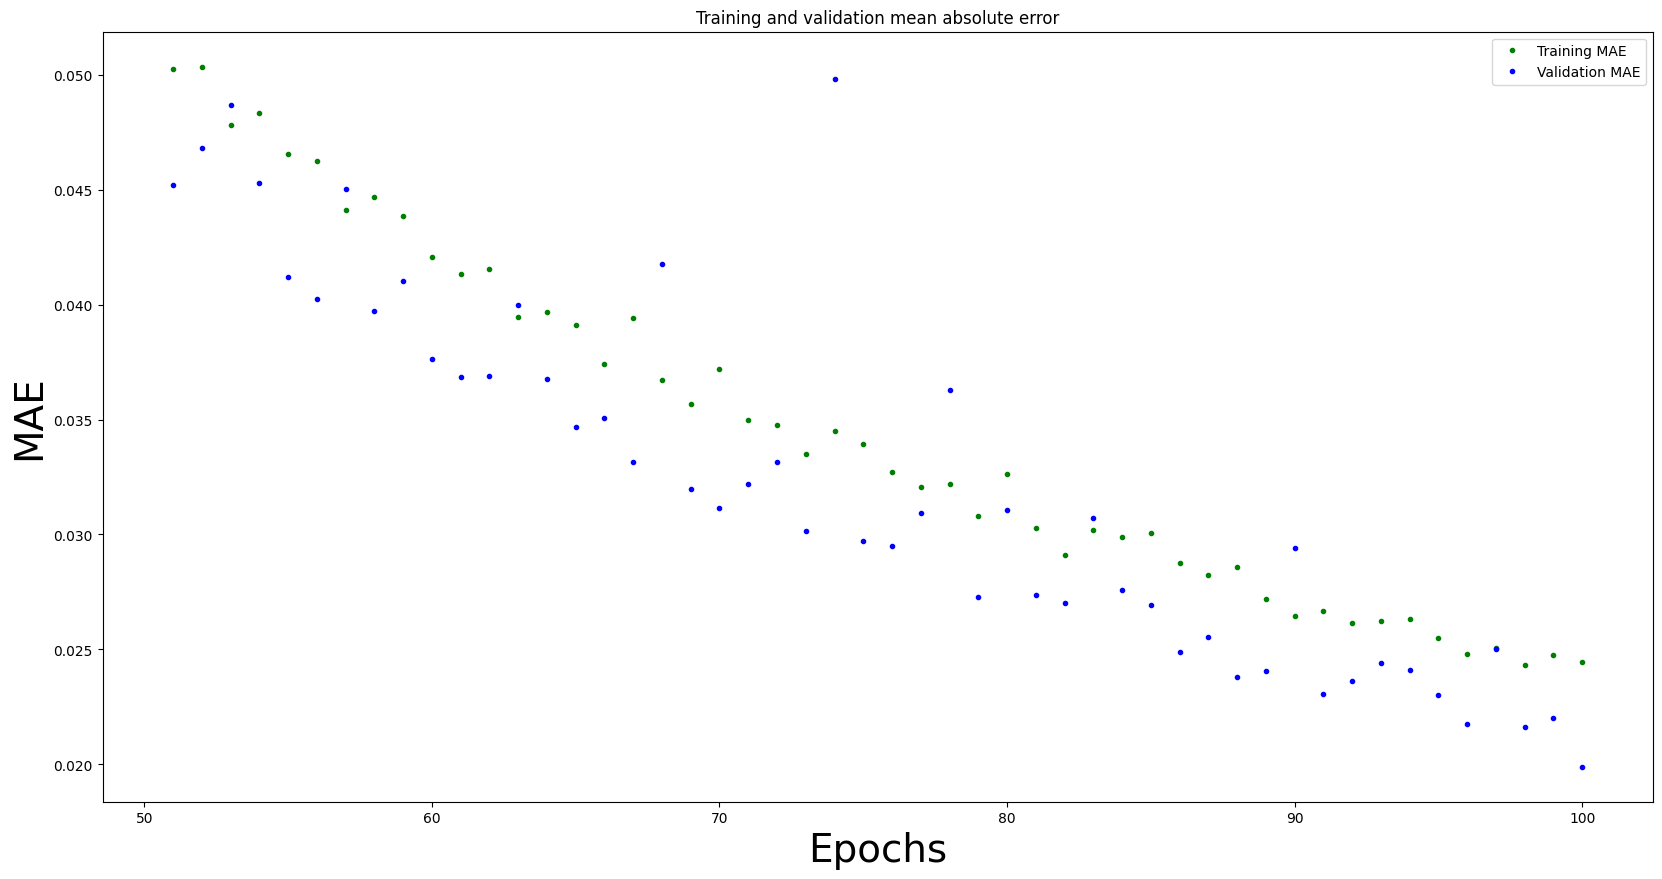

In [ ]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

### Run with Test Data
Put our test data into the model and plot the predictions


In [ ]:
from sklearn.metrics import r2_score
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=2))
print("actual =\n", outputs_test)
print("\nr2 score = ", r2_score(predictions, outputs_test))

16/16 [==============================] - 0s 951us/step
predictions =
 [[0.   0.97 0.02 0.   0.01]
 [0.65 0.   0.   0.35 0.  ]
 [0.   0.   0.   1.   0.  ]
 ...
 [0.   0.   0.   1.   0.  ]
 [0.   0.01 0.99 0.   0.  ]
 [0.03 0.87 0.01 0.   0.09]]
actual =
 [[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]

r2 score =  0.9234052034180646


In [ ]:
from tabulate import tabulate

In [ ]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# round the predictions to two decimal places
rounded_predictions = np.round(predictions, decimals=2)

# create a table with the rounded predictions and actual outputs
table_data = [["Predictions"] + list(rounded_predictions.flatten()),
              ["Actual"] + list(outputs_test.flatten())]

# print the table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))


16/16 [==============================] - 0s 1ms/step
╒═══════════════╤═══════╤════════╤════════╤═══════╤════════╤════════╤═══════╤═══════╤════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤═══════╤═══════╤════════╤═══════╤═══════╤════════╤════════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤════════╤═══════╤════════╤═══════╤════════╤════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤════════╤═══════╤════════╤═══════╤════════╤════════╤═══════╤════════╤═══════╤═══════╤═══════╤═══════╤════════╤═══════╤════════╤═══════╤═══════╤════════╤═══════╤════════╤═══════╤═══════╤════════╤═══════╤════════╤═══════╤═══════╤════════╤════════╤═══════╤═══════╤════════╤═══════╤═══════╤════════╤════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤════════╤═══════╤═══════╤════════╤════════╤════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤═══════╤═══════╤═══════╤═══════╤═══════╤════════╤

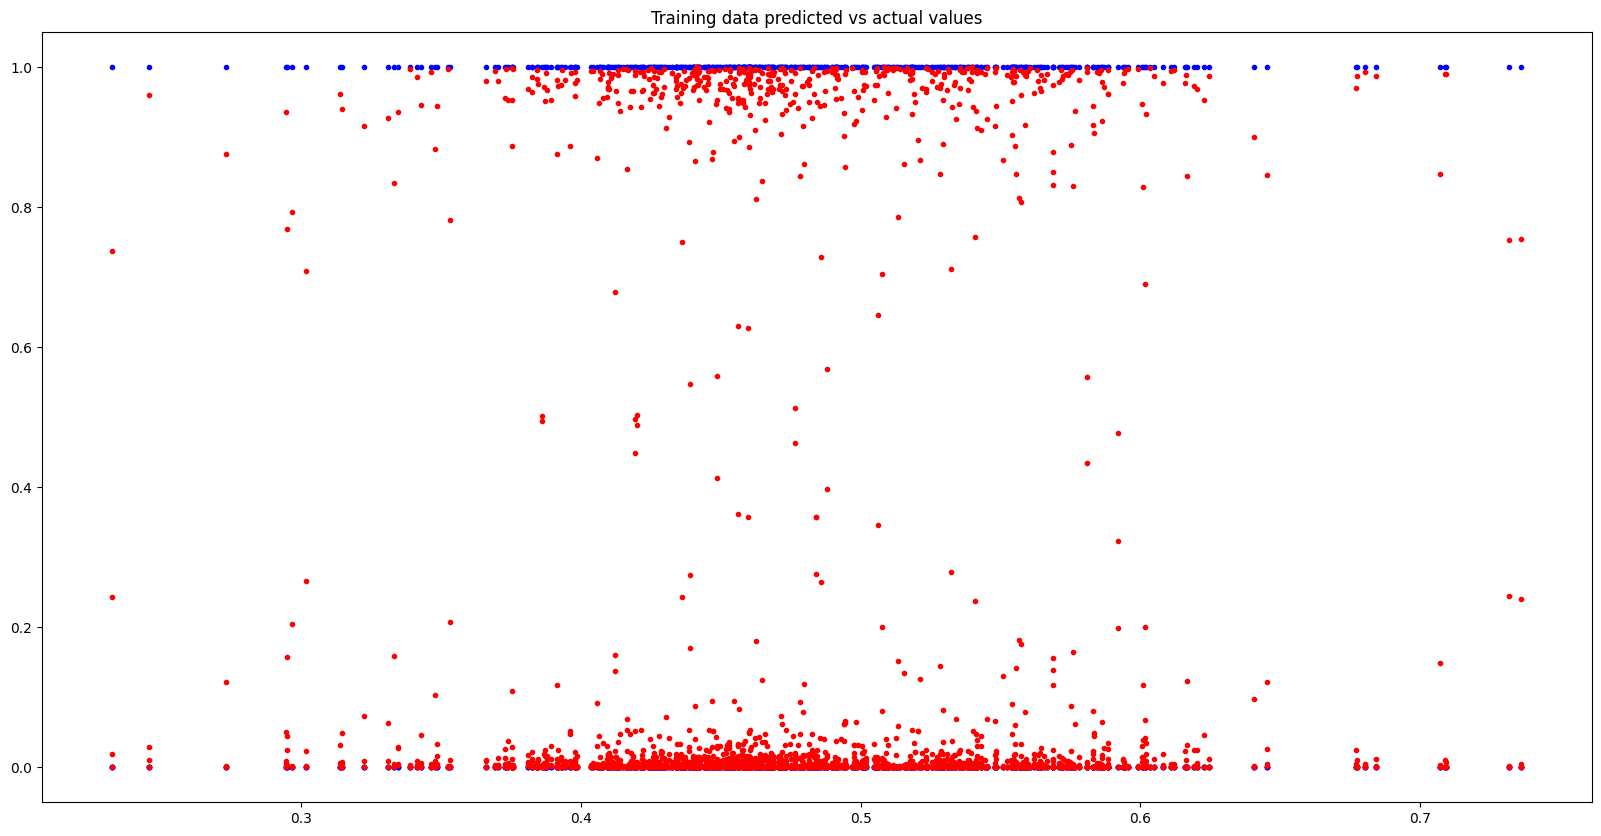

In [ ]:

# Plot the predictions along with to the test data
plt.clf()

plt.title('Training data predicted vs actual values')
plt.plot(inputs_test[:,0], outputs_test, 'b.', label='Actual')
plt.plot(inputs_test[:,0], predictions, 'r.', label='Predicted')
plt.show()

In [ ]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# apply threshold to predictions
threshold = 0.9
binary_predictions = np.where(predictions > threshold, 1, 0)

# print the binary predictions and the expected outputs
# print("predictions (binary) =\n", binary_predictions)
# print("actual =\n", outputs_test)


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
cm = multilabel_confusion_matrix(outputs_test, binary_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[[407   0]
  [  9  94]]

 [[409   1]
  [ 31  69]]

 [[413   0]
  [  7  90]]

 [[421   0]
  [  4  85]]

 [[386   3]
  [ 19 102]]]


# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

Model is 78900 bytes


In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 915,612 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
